## Importing Required Libraries

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import MinMaxScaler

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load the Models and Test Set

In [3]:
X_test= pd.read_csv('../data/X_test_processed.csv')
y_test= pd.read_csv('../data/y_test.csv')
print("Test Data loaded successfully!")

# Load the trained models
models= {
    'Random Forest': joblib.load('../models/Random Forest (Tuned)_model.pkl'),
    'Logistic Regression': joblib.load('../models/Logistic Regression (Tuned)_model.pkl'),
    'XGBoost': joblib.load('../models/XGBoost (Tuned)_model.pkl')
}
print("Trained models loaded successfully!")

Test Data loaded successfully!
Trained models loaded successfully!


## Confusion Matrix Visualization

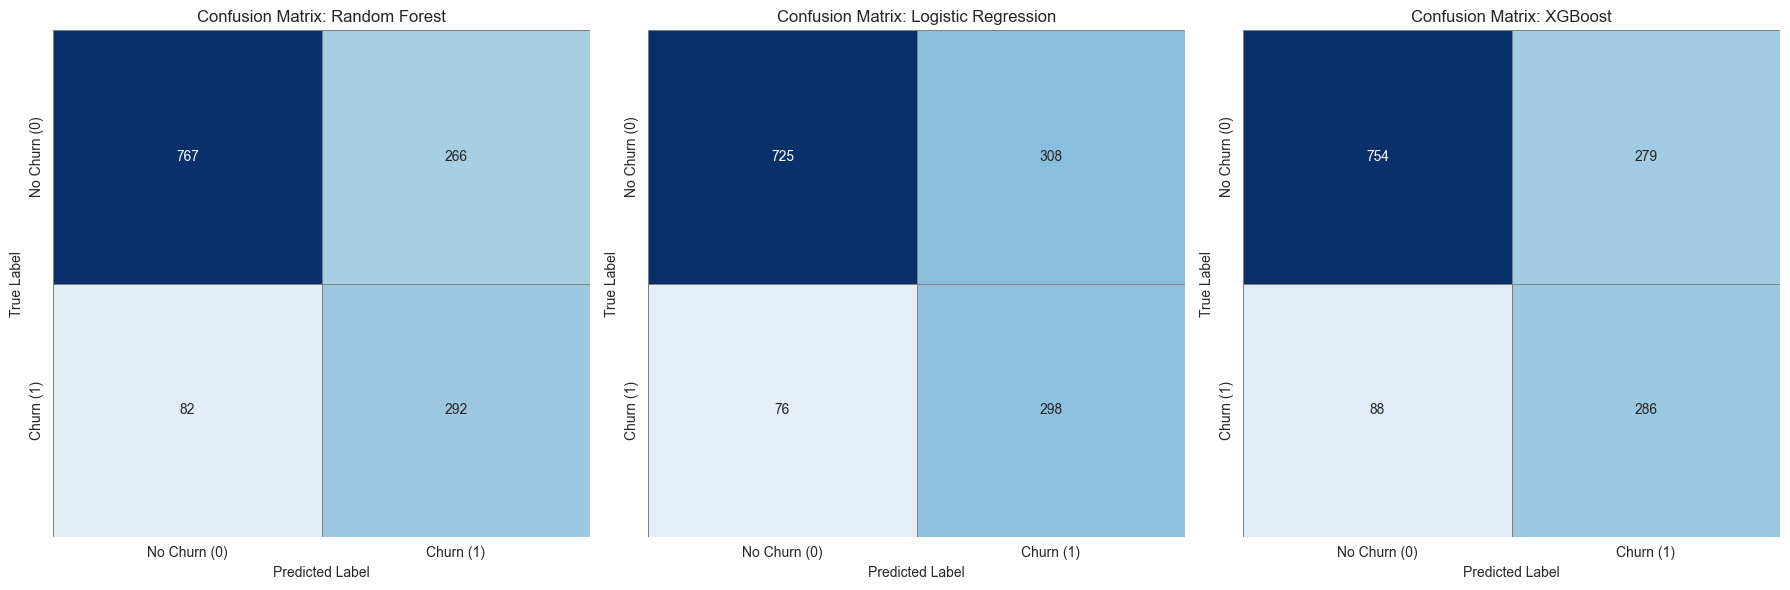

In [4]:
sns.set_style("whitegrid")

fig, axes= plt.subplots(nrows=1, ncols=3, figsize=(18,6))
axes= axes.flatten()

for i, (name, model) in enumerate(models.items()):
    y_pred= model.predict(X_test)
    cm= confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5, linecolor='gray', ax= axes[i], vmin=0)
    axes[i].set_title(f'Confusion Matrix: {name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
    axes[i].set_xticklabels(['No Churn (0)', 'Churn (1)'])
    axes[i].set_yticklabels(['No Churn (0)', 'Churn (1)'])

plt.tight_layout()
plt.show()

### From the results:

- Random Forest achieves strong TNs and a balanced trade-off between TPs and FPs.

- Logistic Regression identifies more churners (higher recall), but at the cost of more false positives.

- XGBoost balances recall and precision, misclassifying fewer negatives compared to Logistic Regression.

## ROC Curve Visualization

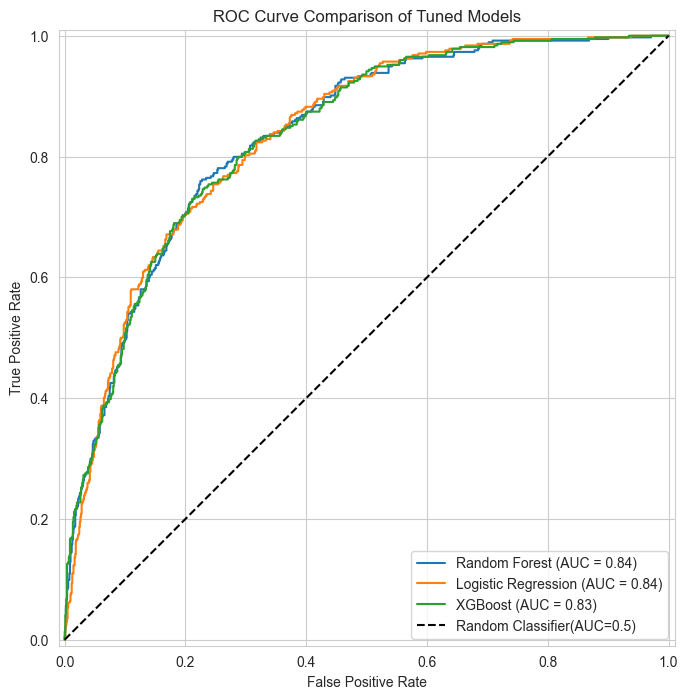

In [5]:
plt.figure(figsize=(10,8))

for name, model in models.items():
    y_proba= model.predict_proba(X_test)[:,1]
    roc_auc= roc_auc_score(y_test, y_proba)

    RocCurveDisplay.from_estimator(model, X_test, y_test, name=f'{name}', ax= plt.gca())

plt.plot([0, 1],[0, 1], 'k--', label='Random Classifier(AUC=0.5)')
plt.title('ROC Curve Comparison of Tuned Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

- The ROC curves compare the models’ ability to distinguish between churners and non-churners at various thresholds.

- All three tuned models (Random Forest, Logistic Regression, XGBoost) achieve similar AUC values (~0.83–0.84), confirming consistent discriminatory power.

- Key takeaway: while the ROC curves are close, Logistic Regression edges slightly in AUC, whereas Random Forest and XGBoost provide better balance in overall performance when paired with their F1-scores.

## Feature Importance Plot

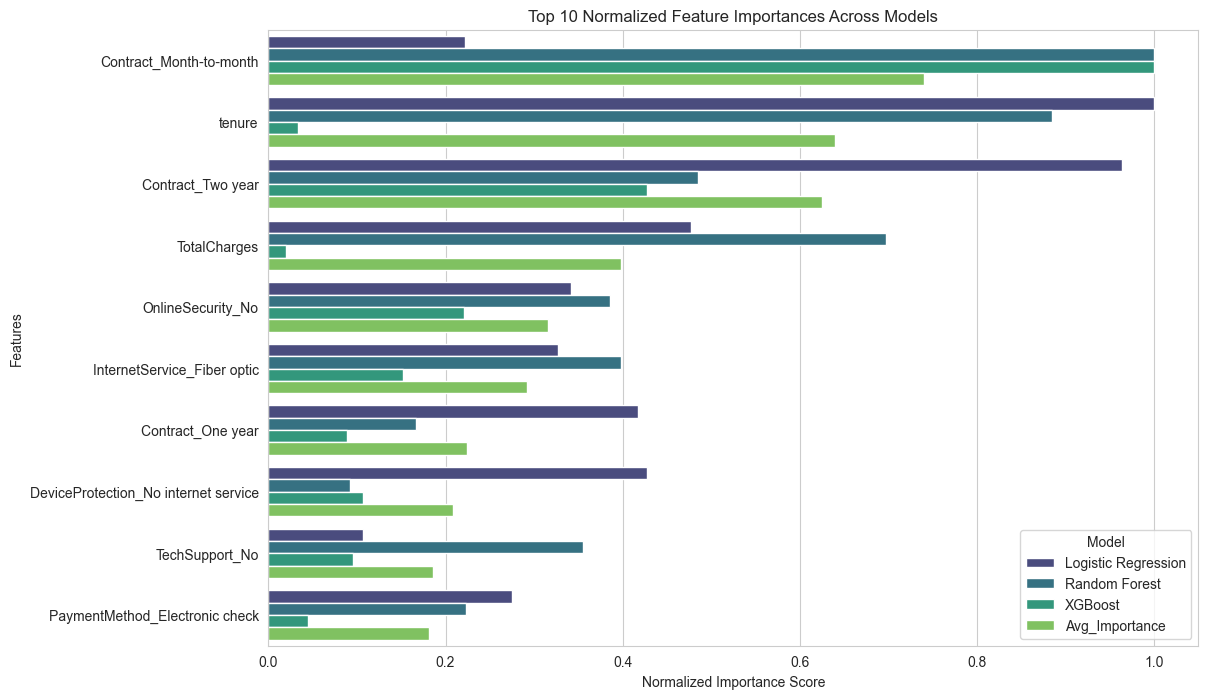

In [6]:
log_reg = joblib.load('../models/Logistic Regression (Tuned)_model.pkl')
rf = joblib.load('../models/Random Forest (Tuned)_model.pkl')
xgb = joblib.load('../models/XGBoost (Tuned)_model.pkl')

lr_coeff= np.abs(log_reg.coef_[0])
rf_importances= rf.feature_importances_
xgb_importances= xgb.feature_importances_

feature_df= pd.DataFrame({
    'Features': X_test.columns,
    'Logistic Regression': lr_coeff,
    'Random Forest': rf_importances,
    'XGBoost': xgb_importances
})

# Normalize the values so they are on a comparable scale (0 to 1)
scaler= MinMaxScaler()
normalized_features= scaler.fit_transform(feature_df.iloc[:,1:])
normalized_df= pd.DataFrame(normalized_features, columns=['Logistic Regression', 'Random Forest', 'XGBoost'])
normalized_df['Features']= X_test.columns

# Sort by the average importance score
normalized_df['Avg_Importance']= normalized_df.iloc[:, :-1].mean(axis=1)
normalized_df.sort_values(by='Avg_Importance', ascending=False, inplace=True)

# Melt the DataFrame to a long format for plotting
plot_df= normalized_df.head(10).melt(id_vars='Features', var_name='Model', value_name='Importance')

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Features', hue='Model', data=plot_df, palette='viridis')
plt.title('Top 10 Normalized Feature Importances Across Models')
plt.xlabel('Normalized Importance Score')
plt.ylabel('Features')
plt.show()

## Key features driving churn prediction across models include:

- `Contract type (Month-to-month, One year, Two year)` – short-term contracts strongly increase churn risk.

- `Tenure` – longer tenure reduces churn likelihood.

- `TotalCharges` – customers with lower overall charges tend to churn more.

- `Payment Method (Electronic check)` – strongly associated with churn.

- `TechSupport` and `OnlineSecurity` – lack of support services increases churn risk.

- `InternetService (Fiber optic)` – higher churn compared to DSL users.

- While the relative importance differs slightly between models (e.g., Random Forest places heavier weight on tenure, while Logistic Regression emphasizes contract type), the general consensus across models highlights contract type, tenure, and service-related variables as the strongest churn predictors.